In [20]:
!pip install MSATwtdenoiser

In [ ]:
# Readind (upload) Files
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

In [21]:
from osgeo import gdal
import numpy as np
import sys
import cv2 
from PIL import Image
from joblib import load
import matplotlib.pyplot as plt
from MSATwtdenoiser import MSATdenoise
import matplotlib.image as mpimg

In [22]:
def hist_norm(source, template):
    """
    Adjust the pixel values of a grayscale image such that its histogram
    matches that of a target image

    Arguments:
    -----------
        source: np.ndarray
            Image to transform; the histogram is computed over the flattened
            array
        template: np.ndarray
            Template image; can have different dimensions to source
    Returns:
    -----------
        matched: np.ndarray
            The transformed output image
    """
    olddtype = source.dtype
    oldshape = source.shape
    source = source.ravel()
    template = template.ravel()

    s_values, bin_idx, s_counts = np.unique(source, return_inverse=True,
                                            return_counts=True)
    t_values, t_counts = np.unique(template, return_counts=True)
    s_quantiles = np.cumsum(s_counts).astype(np.float64)
    s_quantiles /= s_quantiles[-1]
    t_quantiles = np.cumsum(t_counts).astype(np.float64)
    t_quantiles /= t_quantiles[-1]
    interp_t_values = np.interp(s_quantiles, t_quantiles, t_values)
    interp_t_values = interp_t_values.astype(olddtype)

    return interp_t_values[bin_idx].reshape(oldshape)

In [27]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# LOADING TILES

In [28]:
ms = Image.open('/content/drive/MyDrive/ProjectWork/data/rmst.png') # real MS file

In [29]:
pan = Image.open('/content/drive/MyDrive/ProjectWork/data/pant.png') # PAN Chromatic

In [30]:

pan.size

(512, 512)

In [31]:
ms.size

(128, 128)

# Upscale LRMS file (4x)

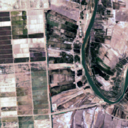

In [32]:
ms

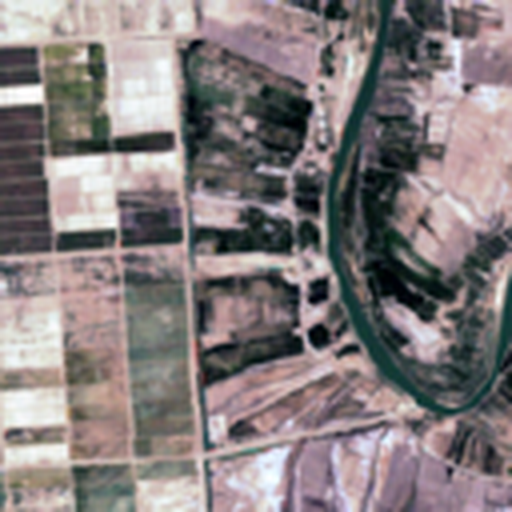

In [33]:
xms = ms.resize((512,512),resample=Image.LANCZOS)
xms

# Average Weight Calculation

In [34]:
ms_array = np.array(xms)

In [35]:
weighted_avg = np.average(ms_array)
print(f"LRMS average weigth is {weighted_avg:.2f} rounded to 2 decimal points")

LRMS average weigth is 128.84 rounded to 2 decimal points


ATWT

In [36]:
ms_arr = np.mean(ms_array,axis=2)
ms_arr = ms_arr+np.random.normal(0,100,[np.shape(ms_arr)[0],np.shape(ms_arr)[1]])
denoiser = MSATdenoise(ms_arr,'db3',3) # wavelet name from dt1 to dt5 and level from 1 to 5
denoised_img = denoiser.denoised

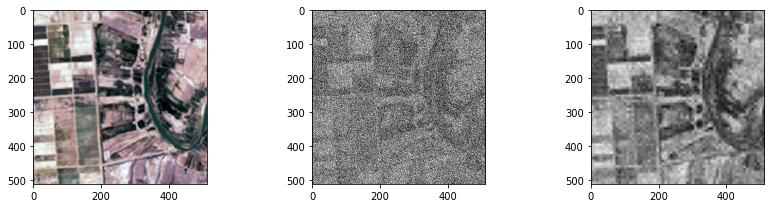

In [37]:
fig = plt.figure(figsize=(12, 3))
ax = fig.add_subplot(1, 3, 1)
ax.imshow(ms_array, interpolation="nearest", cmap=plt.cm.gray)
ax = fig.add_subplot(1, 3, 2)
ax.imshow(ms_arr, interpolation="nearest", cmap=plt.cm.gray)
ax = fig.add_subplot(1, 3, 3)
ax.imshow(denoised_img, interpolation="nearest", cmap=plt.cm.gray)
fig.tight_layout() #automatically adjust subplot parameters to give specified padding
plt.show()

# Displaying PAN image

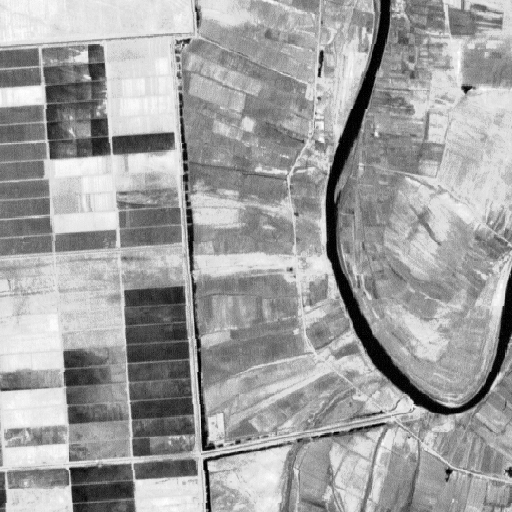

In [ ]:
pan

Histogram matched PAN

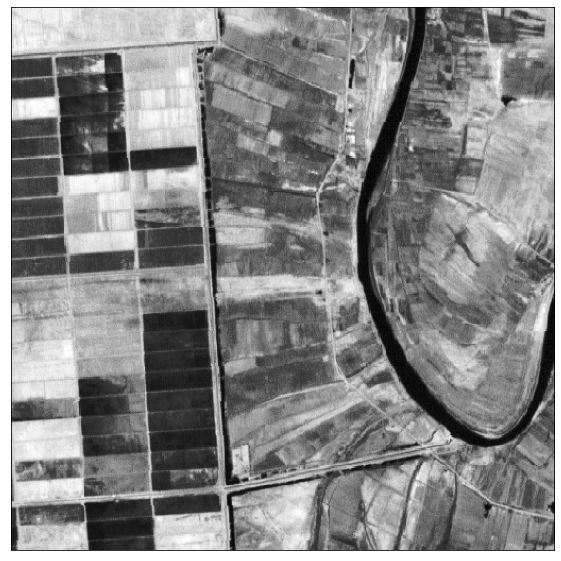

In [ ]:
pan_array = np.array(pan)
matched_pan = hist_norm(pan_array,ms_array)
plt.figure(figsize=(10,10))
plt.xticks([])
plt.yticks([])
plt.imshow(matched_pan)
plt.show()

In [ ]:
def ecdf(x):
    """convenience function for computing the empirical CDF"""
    vals, counts = np.unique(x, return_counts=True)
    ecdf = np.cumsum(counts).astype(np.float64)
    ecdf /= ecdf[-1]
    return vals, ecdf

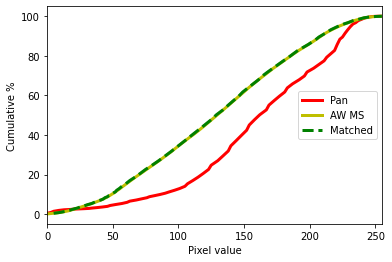

In [ ]:
x1, y1 = ecdf(pan_array.ravel())
x2, y2 = ecdf(ms_array.ravel())=
x3, y3 = ecdf(matched_pan.ravel())
plt.plot(x1, y1 * 100, '-r', lw=3, label='Pan')
plt.plot(x2, y2 * 100, '-y', lw=3, label='AW MS')
plt.plot(x3, y3 * 100, '--g', lw=3, label='Matched')
plt.xlim(x1[0], x1[-1])
plt.xlabel('Pixel value')
plt.ylabel('Cumulative %')
plt.legend(loc=5)
plt.show()

Guided filter on matched PAN

In [ ]:
import scipy as sp
import scipy.ndimage


def box(img, r):
    """ O(1) box filter
        img - >= 2d image
        r   - radius of box filter
    """
    (rows, cols) = img.shape[:2]
    imDst = np.zeros_like(img)


    tile = [1] * img.ndim
    tile[0] = r
    imCum = np.cumsum(img, 0)
    imDst[0:r+1, :, ...] = imCum[r:2*r+1, :, ...]
    imDst[r+1:rows-r, :, ...] = imCum[2*r+1:rows, :, ...] - imCum[0:rows-2*r-1, :, ...]
    imDst[rows-r:rows, :, ...] = np.tile(imCum[rows-1:rows, :, ...], tile) - imCum[rows-2*r-1:rows-r-1, :, ...]

    tile = [1] * img.ndim
    tile[1] = r
    imCum = np.cumsum(imDst, 1)
    imDst[:, 0:r+1, ...] = imCum[:, r:2*r+1, ...]
    imDst[:, r+1:cols-r, ...] = imCum[:, 2*r+1 : cols, ...] - imCum[:, 0 : cols-2*r-1, ...]
    imDst[:, cols-r: cols, ...] = np.tile(imCum[:, cols-1:cols, ...], tile) - imCum[:, cols-2*r-1 : cols-r-1, ...]

    return imDst

def _gf_color(I, p, r, eps, s=None):
    """ Color guided filter
    I - guide image (rgb)
    p - filtering input (single channel)
    r - window radius
    eps - regularization (roughly, variance of non-edge noise)
    s - subsampling factor for fast guided filter
    """
    fullI = I
    fullP = p
    if s is not None:
        I = sp.ndimage.zoom(fullI, [1/s, 1/s, 1], order=1)
        p = sp.ndimage.zoom(fullP, [1/s, 1/s], order=1)
        r = round(r / s)

    h, w = p.shape[:2]
    N = box(np.ones((h, w)), r)

    mI_r = box(I[:,:,0], r) / N
    mI_g = box(I[:,:,1], r) / N
    mI_b = box(I[:,:,2], r) / N

    mP = box(p, r) / N

    # mean of I * p
    mIp_r = box(I[:,:,0]*p, r) / N
    mIp_g = box(I[:,:,1]*p, r) / N
    mIp_b = box(I[:,:,2]*p, r) / N

    # per-patch covariance of (I, p)
    covIp_r = mIp_r - mI_r * mP
    covIp_g = mIp_g - mI_g * mP
    covIp_b = mIp_b - mI_b * mP

    # symmetric covariance matrix of I in each patch:
    #       rr rg rb
    #       rg gg gb
    #       rb gb bb
    var_I_rr = box(I[:,:,0] * I[:,:,0], r) / N - mI_r * mI_r;
    var_I_rg = box(I[:,:,0] * I[:,:,1], r) / N - mI_r * mI_g;
    var_I_rb = box(I[:,:,0] * I[:,:,2], r) / N - mI_r * mI_b;

    var_I_gg = box(I[:,:,1] * I[:,:,1], r) / N - mI_g * mI_g;
    var_I_gb = box(I[:,:,1] * I[:,:,2], r) / N - mI_g * mI_b;

    var_I_bb = box(I[:,:,2] * I[:,:,2], r) / N - mI_b * mI_b;

    a = np.zeros((h, w, 3))
    for i in range(h):
        for j in range(w):
            sig = np.array([
                [var_I_rr[i,j], var_I_rg[i,j], var_I_rb[i,j]],
                [var_I_rg[i,j], var_I_gg[i,j], var_I_gb[i,j]],
                [var_I_rb[i,j], var_I_gb[i,j], var_I_bb[i,j]]
            ])
            covIp = np.array([covIp_r[i,j], covIp_g[i,j], covIp_b[i,j]])
            a[i,j,:] = np.linalg.solve(sig + eps * np.eye(3), covIp)

    b = mP - a[:,:,0] * mI_r - a[:,:,1] * mI_g - a[:,:,2] * mI_b

    meanA = box(a, r) / N[...,np.newaxis]
    meanB = box(b, r) / N

    if s is not None:
        meanA = sp.ndimage.zoom(meanA, [s, s, 1], order=1)
        meanB = sp.ndimage.zoom(meanB, [s, s], order=1)

    q = np.sum(meanA * fullI, axis=2) + meanB

    return q


def _gf_gray(I, p, r, eps, s=None):
    """ grayscale (fast) guided filter
        I - guide image (1 channel)
        p - filter input (1 channel)
        r - window raidus
        eps - regularization (roughly, allowable variance of non-edge noise)
        s - subsampling factor for fast guided filter
    """
    if s is not None:
        Isub = sp.ndimage.zoom(I, 1/s, order=1)
        Psub = sp.ndimage.zoom(p, 1/s, order=1)
        r = round(r / s)
    else:
        Isub = I
        Psub = p


    (rows, cols) = Isub.shape

    N = box(np.ones([rows, cols]), r)

    meanI = box(Isub, r) / N
    meanP = box(Psub, r) / N
    corrI = box(Isub * Isub, r) / N
    corrIp = box(Isub * Psub, r) / N
    varI = corrI - meanI * meanI
    covIp = corrIp - meanI * meanP


    a = covIp / (varI + eps)
    b = meanP - a * meanI

    meanA = box(a, r) / N
    meanB = box(b, r) / N

    if s is not None:
        meanA = sp.ndimage.zoom(meanA, s, order=1)
        meanB = sp.ndimage.zoom(meanB, s, order=1)

    q = meanA * I + meanB
    return q


def _gf_colorgray(I, p, r, eps, s=None):
    """ automatically choose color or gray guided filter based on I's shape """
    if I.ndim == 2 or I.shape[2] == 1:
        return _gf_gray(I, p, r, eps, s)
    elif I.ndim == 3 and I.shape[2] == 3:
        return _gf_color(I, p, r, eps, s)
    else:
        print("Invalid guide dimensions:", I.shape)
def guided_filter(I, p, r, eps, s=None):
    """ run a guided filter per-channel on filtering input p
        I - guide image (1 or 3 channel)
        p - filter input (n channel)
        r - window raidus
        eps - regularization (roughly, allowable variance of non-edge noise)
        s - subsampling factor for fast guided filter
    """
    if p.ndim == 2:
        p3 = p[:,:,np.newaxis]

    out = np.zeros_like(p3)
    for ch in range(p3.shape[2]):
        out[:,:,ch] = _gf_colorgray(I, p3[:,:,ch], r, eps, s)
    return np.squeeze(out) if p.ndim == 2 else out

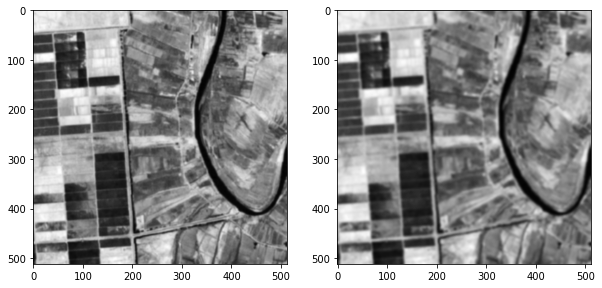

In [ ]:
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(10,10))
r = 10
eps = 0.5
ms_arr2 = np.max(ms_array.astype(np.float32) / 255, axis=2)
matched_pan2 = np.max(matched_pan.astype(np.float32) / 255,axis=2)
l1 = guided_filter(ms_arr2, matched_pan2, r, eps)
ax[0].imshow(l1,cmap='gray')
r = 2
eps = 0.5
ms_arr2 = np.max(ms_array.astype(np.float32) / 255, axis=2)
matched_pan2 = np.max(matched_pan.astype(np.float32) / 255,axis=2)
l1 = guided_filter(ms_arr2, matched_pan2, r, eps)
ax[1].imshow(l1,cmap='gray')

In [ ]:
pip install sewar

  Created wheel for sewar: filename=sewar-0.4.4-py3-none-any.whl size=10390 sha256=4114ca48a6bec601a64792ec5349b471a8aa69fbc032d51161f0863157249fe9
  Stored in directory: /root/.cache/pip/wheels/b5/00/df/f1ba40d0d44c95b0db52804e518c128d5631866b91ea1960ba
Successfully built sewar


In [ ]:
>>> from sewar.full_ref import uqi
>>> uqi(l1, matched_pan2)

0.9844287186528735

ATWT on PAN

In [ ]:
pan_arr = np.mean(pan_array,axis=2)
pan_arr = pan_arr+np.random.normal(0,100,[np.shape(pan_arr)[0],np.shape(pan_arr)[1]])
denoiser = MSATdenoise(pan_arr,'db3',3) # wavelet name from dt1 to dt5 and level from 1 to 5
denoised_img = denoiser.denoised

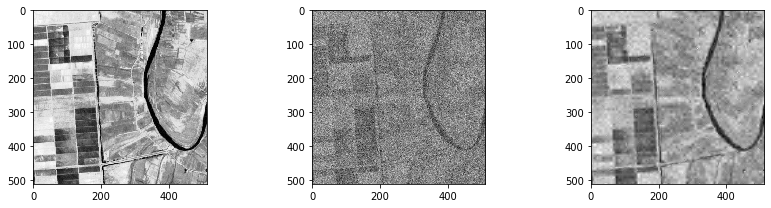

In [ ]:
fig = plt.figure(figsize=(12, 3))
ax = fig.add_subplot(1, 3, 1)
ax.imshow(pan_array, interpolation="nearest", cmap=plt.cm.gray)
ax = fig.add_subplot(1, 3, 2)
ax.imshow(pan_arr, interpolation="nearest", cmap=plt.cm.gray)
ax = fig.add_subplot(1, 3, 3)
ax.imshow(denoised_img, interpolation="nearest", cmap=plt.cm.gray)
fig.tight_layout() #automatically adjust subplot parameters to give specified padding
plt.show()

In [ ]:
>> from sewar.full_ref import uqi
>>> uqi(pan_array,pan_arr, denoised_img)

guided filter on lrms

In [ ]:
import scipy as sp
import scipy.ndimage


def box(img, r):
    """ O(1) box filter
        img - >= 2d image
        r   - radius of box filter
    """
    (rows, cols) = img.shape[:2]
    imDst = np.zeros_like(img)


    tile = [1] * img.ndim
    tile[0] = r
    imCum = np.cumsum(img, 0)
    imDst[0:r+1, :, ...] = imCum[r:2*r+1, :, ...]
    imDst[r+1:rows-r, :, ...] = imCum[2*r+1:rows, :, ...] - imCum[0:rows-2*r-1, :, ...]
    imDst[rows-r:rows, :, ...] = np.tile(imCum[rows-1:rows, :, ...], tile) - imCum[rows-2*r-1:rows-r-1, :, ...]

    tile = [1] * img.ndim
    tile[1] = r
    imCum = np.cumsum(imDst, 1)
    imDst[:, 0:r+1, ...] = imCum[:, r:2*r+1, ...]
    imDst[:, r+1:cols-r, ...] = imCum[:, 2*r+1 : cols, ...] - imCum[:, 0 : cols-2*r-1, ...]
    imDst[:, cols-r: cols, ...] = np.tile(imCum[:, cols-1:cols, ...], tile) - imCum[:, cols-2*r-1 : cols-r-1, ...]

    return imDst

def _gf_color(I, p, r, eps, s=None):
    """ Color guided filter
    I - guide image (rgb)
    p - filtering input (single channel)
    r - window radius
    eps - regularization (roughly, variance of non-edge noise)
    s - subsampling factor for fast guided filter
    """
    fullI = I
    fullP = p
    if s is not None:
        I = sp.ndimage.zoom(fullI, [1/s, 1/s, 1], order=1)
        p = sp.ndimage.zoom(fullP, [1/s, 1/s], order=1)
        r = round(r / s)

    h, w = p.shape[:2]
    N = box(np.ones((h, w)), r)

    mI_r = box(I[:,:,0], r) / N
    mI_g = box(I[:,:,1], r) / N
    mI_b = box(I[:,:,2], r) / N

    mP = box(p, r) / N

    # mean of I * p
    mIp_r = box(I[:,:,0]*p, r) / N
    mIp_g = box(I[:,:,1]*p, r) / N
    mIp_b = box(I[:,:,2]*p, r) / N

    # per-patch covariance of (I, p)
    covIp_r = mIp_r - mI_r * mP
    covIp_g = mIp_g - mI_g * mP
    covIp_b = mIp_b - mI_b * mP

    # symmetric covariance matrix of I in each patch:
    #       rr rg rb
    #       rg gg gb
    #       rb gb bb
    var_I_rr = box(I[:,:,0] * I[:,:,0], r) / N - mI_r * mI_r;
    var_I_rg = box(I[:,:,0] * I[:,:,1], r) / N - mI_r * mI_g;
    var_I_rb = box(I[:,:,0] * I[:,:,2], r) / N - mI_r * mI_b;

    var_I_gg = box(I[:,:,1] * I[:,:,1], r) / N - mI_g * mI_g;
    var_I_gb = box(I[:,:,1] * I[:,:,2], r) / N - mI_g * mI_b;

    var_I_bb = box(I[:,:,2] * I[:,:,2], r) / N - mI_b * mI_b;

    a = np.zeros((h, w, 3))
    for i in range(h):
        for j in range(w):
            sig = np.array([
                [var_I_rr[i,j], var_I_rg[i,j], var_I_rb[i,j]],
                [var_I_rg[i,j], var_I_gg[i,j], var_I_gb[i,j]],
                [var_I_rb[i,j], var_I_gb[i,j], var_I_bb[i,j]]
            ])
            covIp = np.array([covIp_r[i,j], covIp_g[i,j], covIp_b[i,j]])
            a[i,j,:] = np.linalg.solve(sig + eps * np.eye(3), covIp)

    b = mP - a[:,:,0] * mI_r - a[:,:,1] * mI_g - a[:,:,2] * mI_b

    meanA = box(a, r) / N[...,np.newaxis]
    meanB = box(b, r) / N

    if s is not None:
        meanA = sp.ndimage.zoom(meanA, [s, s, 1], order=1)
        meanB = sp.ndimage.zoom(meanB, [s, s], order=1)

    q = np.sum(meanA * fullI, axis=2) + meanB

    return q


def _gf_gray(I, p, r, eps, s=None):
    """ grayscale (fast) guided filter
        I - guide image (1 channel)
        p - filter input (1 channel)
        r - window raidus
        eps - regularization (roughly, allowable variance of non-edge noise)
        s - subsampling factor for fast guided filter
    """
    if s is not None:
        Isub = sp.ndimage.zoom(I, 1/s, order=1)
        Psub = sp.ndimage.zoom(p, 1/s, order=1)
        r = round(r / s)
    else:
        Isub = I
        Psub = p


    (rows, cols) = Isub.shape

    N = box(np.ones([rows, cols]), r)

    meanI = box(Isub, r) / N
    meanP = box(Psub, r) / N
    corrI = box(Isub * Isub, r) / N
    corrIp = box(Isub * Psub, r) / N
    varI = corrI - meanI * meanI
    covIp = corrIp - meanI * meanP


    a = covIp / (varI + eps)
    b = meanP - a * meanI

    meanA = box(a, r) / N
    meanB = box(b, r) / N

    if s is not None:
        meanA = sp.ndimage.zoom(meanA, s, order=1)
        meanB = sp.ndimage.zoom(meanB, s, order=1)

    q = meanA * I + meanB
    return q


def _gf_colorgray(I, p, r, eps, s=None):
    """ automatically choose color or gray guided filter based on I's shape """
    if I.ndim == 2 or I.shape[2] == 1:
        return _gf_gray(I, p, r, eps, s)
    elif I.ndim == 3 and I.shape[2] == 3:
        return _gf_color(I, p, r, eps, s)
    else:
        print("Invalid guide dimensions:", I.shape)
def guided_filter(I, p, r, eps, s=None):
    """ run a guided filter per-channel on filtering input p
        I - guide image (1 or 3 channel)
        p - filter input (n channel)
        r - window raidus
        eps - regularization (roughly, allowable variance of non-edge noise)
        s - subsampling factor for fast guided filter
    """
    if p.ndim == 2:
        p3 = p[:,:,np.newaxis]

    out = np.zeros_like(p3)
    for ch in range(p3.shape[2]):
        out[:,:,ch] = _gf_colorgray(I, p3[:,:,ch], r, eps, s)
    return np.squeeze(out) if p.ndim == 2 else out

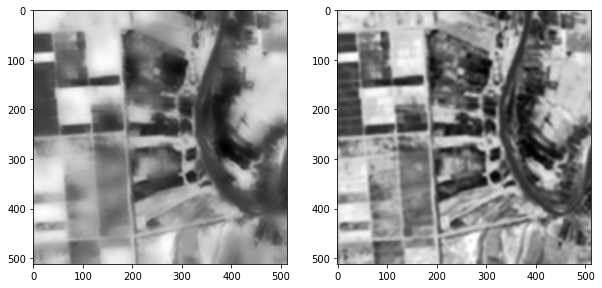

In [ ]:
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(10,10))
r = 10
eps = 0.05
xms_arr2 = np.max(ms_array.astype(np.float32) / 255, axis=2)
xms2 = np.max(ms_array.astype(np.float32) / 255,axis=2)
l1 = guided_filter(ms_arr2,xms2, r, eps)
ax[0].imshow(l1,cmap='gray')
r = 2
eps = 0.1
xms_arr2 = np.max(ms_array.astype(np.float32) / 255, axis=2)
xms2 = np.max(ms_array.astype(np.float32) / 255,axis=2)
l1 = guided_filter(xms_arr2, xms2, r, eps)
ax[1].imshow(l1,cmap='gray')